In [1]:
import pandas as pd
import numpy as np
import math as m
import statistics as s
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
df = pd.read_csv('https://raw.githubusercontent.com/askidelsky/DAV-6150/main/Homework/Module%2011/M11_Data.csv')

#Nosson Weissman
#Avi Skidelsky

#DAV-6150
#Module 11 Assignment

In [2]:
%matplotlib inline

# Introduction

The dataset being used in this problem is one that we have seen before when we were tasked with trying to predict the number of dropouts that a school may experience in a given year. This time however, we will be trying to classify the rate of students passing their regents per school, either low, medium, or high, this time trying to work on a positive aspect of the school as opposed to a negative aspect. We will try and make use of random forests and decision trees and determining which will be better and evaluating in this situation, whether it is worth sacrificing some accuracy for the simplicity and computational efficiency that comes with running a decision tree.

The attributes associated with this data set can be described as follows:

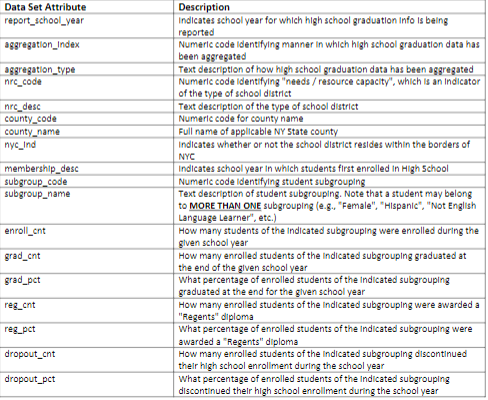





# EDA:

In [3]:
df.head()

,report_school_year,aggregation_index,aggregation_type,aggregation_name,nrc_code,nrc_desc,county_code,county_name,nyc_ind,membership_desc,subgroup_code,subgroup_name,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct
0,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,1,All Students,658,464,71%,310,47%,148,22%
1,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,2,Female,324,246,76%,169,52%,65,20%
2,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,3,Male,334,218,65%,141,42%,83,25%
3,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,4,American Indian/Alaska Native,-,-,-,-,-,-,-
4,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,5,Black,367,248,68%,183,50%,91,25%


In [4]:
df.dtypes

report_school_year    object
aggregation_index      int64
aggregation_type      object
aggregation_name      object
nrc_code               int64
nrc_desc              object
county_code            int64
county_name           object
nyc_ind                int64
membership_desc       object
subgroup_code          int64
subgroup_name         object
enroll_cnt            object
grad_cnt              object
grad_pct              object
reg_cnt               object
reg_pct               object
dropout_cnt           object
dropout_pct           object
dtype: object

Going off of prior experience with this data set, we know that there are tons of missing values that need to be removed since they aren't able to be imputed. This is taken care of below. Additionally, based on the columns listed, we need to convert several of them to numeric values from text in order to construct our new response variable and perform proper analysis.

In [5]:
len(df[df.enroll_cnt == '-'])

33478

In [6]:
df1 = df.drop(df[df['enroll_cnt']=='-'].index)
len(df1[df1.enroll_cnt == '-'])

0

In [7]:
df1['grad_pct']=df1['grad_pct'].str.strip("%").astype(float)/100;
df1['reg_pct']=df1['reg_pct'].str.strip("%").astype(float)/100;
df1['dropout_pct']=df1['dropout_pct'].str.strip("%").astype(float)/100;
df1['enroll_cnt']=df1['enroll_cnt'].astype(float)
df1['grad_cnt']=df1['grad_cnt'].astype(float)
df1['reg_cnt']=df1['reg_cnt'].astype(float)
df1['dropout_cnt']=df1['dropout_cnt'].astype(float)
df1.dtypes

report_school_year     object
aggregation_index       int64
aggregation_type       object
aggregation_name       object
nrc_code                int64
nrc_desc               object
county_code             int64
county_name            object
nyc_ind                 int64
membership_desc        object
subgroup_code           int64
subgroup_name          object
enroll_cnt            float64
grad_cnt              float64
grad_pct              float64
reg_cnt               float64
reg_pct               float64
dropout_cnt           float64
dropout_pct           float64
dtype: object

### Descriptive Statistics and Distributions:
Now that all the data is in its proper form and missing values are removed, we can start to move on to our further analysis.

#### Categorical Variables:

Based on domain knowledge and the description of the data, we are able to identify the below data as categorical, even if they may be represented as numeric.

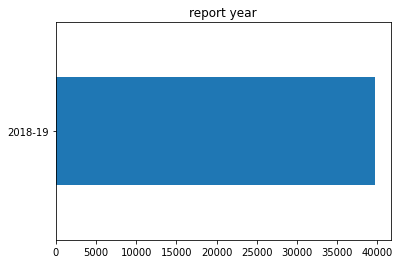

In [8]:
df1['report_school_year'].value_counts().plot(kind='barh', title='report year')

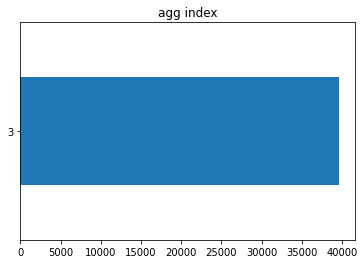

In [9]:
df1['aggregation_index'].value_counts().plot(kind='barh', title='agg index')

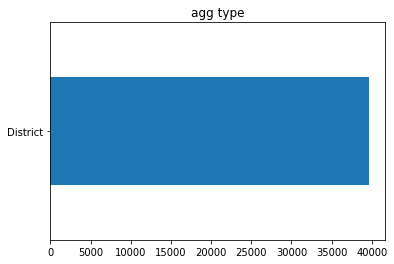

In [10]:
df1['aggregation_type'].value_counts().plot(kind='barh', title='agg type')

The first few categorical variables, membership_desc, aggregation_type, and aggregation_index, have no variance in values. They all have the same value and therefore don't provide any criteria for our decision tree to split on. Since they offer no new information for each variable, we will eliminate these three right away. This will occur in data preparation.

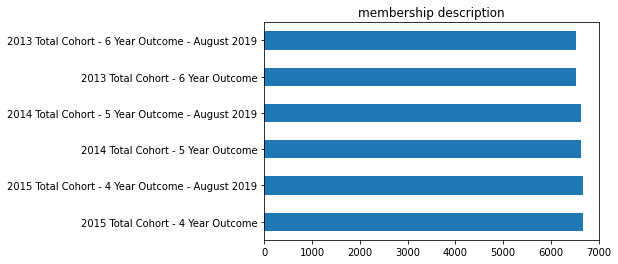

In [11]:
df1['membership_desc'].value_counts().plot(kind='barh', title='membership description')

For membership_desc, even though all memberships have the same amount of observations, they are different and therefore have the potential to be valuable. This will have to be checked together with our response variable to determine entropy.

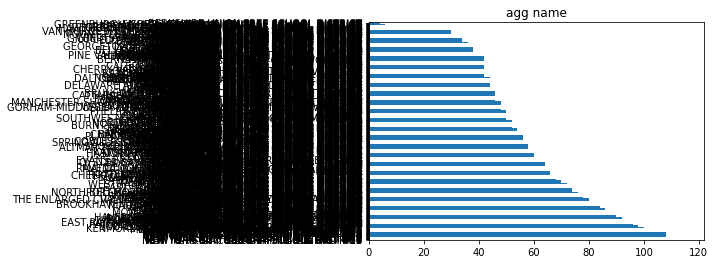

In [12]:
df1['aggregation_name'].value_counts().plot(kind='barh', title='agg name')

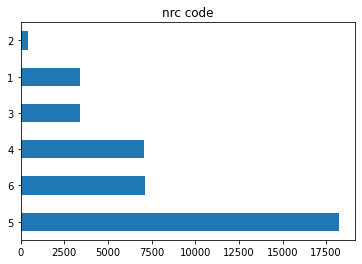

In [13]:
df1['nrc_code'].value_counts().plot(kind='barh', title='nrc code')

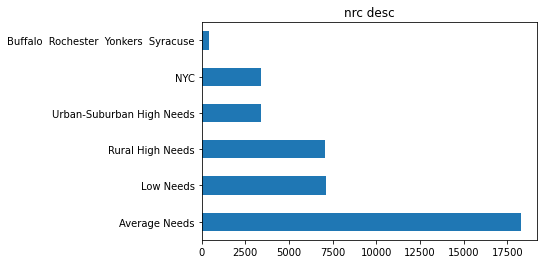

In [14]:
df1['nrc_desc'].value_counts().plot(kind='barh', title='nrc desc')

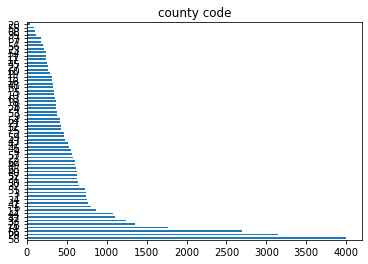

In [15]:
df1['county_code'].value_counts().plot(kind='barh', title='county code')

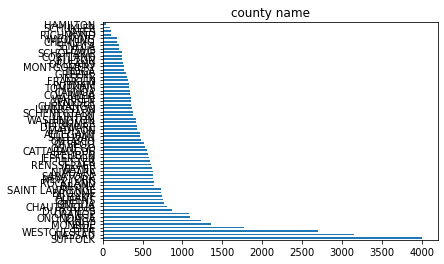

In [16]:
df1['county_name'].value_counts().plot(kind='barh', title='county name')

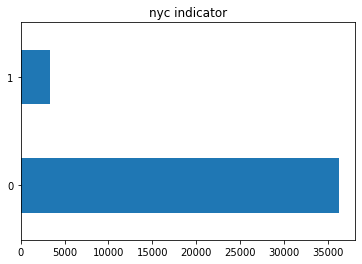

In [17]:
df1['nyc_ind'].value_counts().plot(kind='barh', title='nyc indicator')

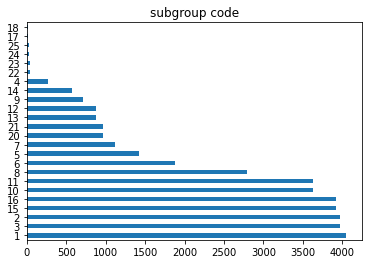

In [18]:
df1['subgroup_code'].value_counts().plot(kind='barh', title='subgroup code')

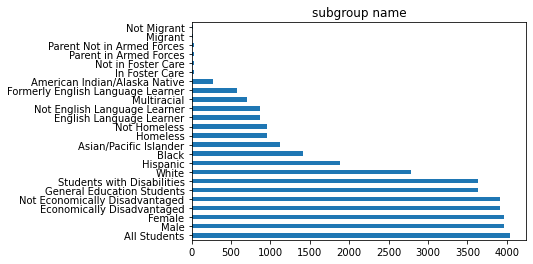

In [19]:
df1['subgroup_name'].value_counts().plot(kind='barh', title='subgroup name')

The above categorical variables all have a significant amount of variance and multiple categories which make them good candidates for being included in our model. A few of the variables, subgroup, county, and nrc, all have both "code" and "desc"/"name" fields and obviously, both are not needed. We will elect to drop the "code" fields since they are coded as integers and can be easily misinterpreted by the models. This change will occur in the data prep step.

Something to note however, the subgroups, counties, and aggregation_name all have tons of categories that if we would create dummy variables we would have hundreds of options and it would introduce a lot of unnecessary noise. We know that decision classification trees are prone to overfitting and including categorical data that gets to this granular of a level can impact that risk negatively. Therefore, these fields will be taken out in data transformation.

In [20]:
df1.iloc[:,12:].describe()

,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct
count,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000
mean,192.120079,161.178354,0.844066,86.804708,0.433711,16.239225,0.079630
std,439.972474,361.294773,0.156795,225.795826,0.171249,50.129834,0.096587
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,20.000000,0.790000,10.000000,0.330000,1.000000,0.010000
50%,66.000000,57.000000,0.890000,27.000000,0.430000,3.000000,0.050000
75%,179.000000,156.000000,0.950000,69.000000,0.530000,9.000000,0.110000
max,9176.000000,7540.000000,1.000000,4752.000000,1.000000,1091.000000,1.000000


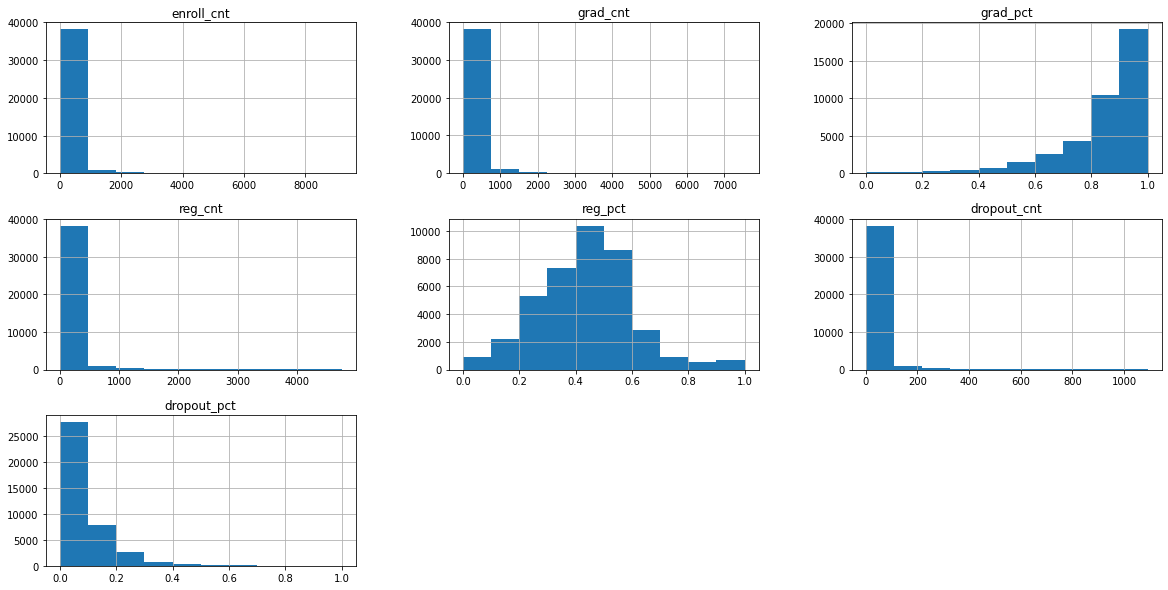

In [21]:
df1.iloc[:,12:].hist(bins=10, figsize=(20,10))
plt.show()

Looking at above histograms, several of the variables have nearly identical distributions and will need to be examined. However, we will likely be able to gain more information on the colinearity of these variables after the creation of our response variable.

One insight that we can gain right away is from the fields of reg_pct and grad_pct. Based on the fact that their distributions are more spread out than the others, there is more information to learn from them so they will likely be very important variables to be included in our model. This is obvious for reg_pct since the response variable that will be created is going to be based off of it.

In [22]:
df1.iloc[:,12:].head()

,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct
0,658.0,464.0,0.71,310.0,0.47,148.0,0.22
1,324.0,246.0,0.76,169.0,0.52,65.0,0.20
2,334.0,218.0,0.65,141.0,0.42,83.0,0.25
4,367.0,248.0,0.68,183.0,0.50,91.0,0.25
5,98.0,58.0,0.59,40.0,0.41,28.0,0.29


Looking at a sample of the rows above, you can see that all of the "pct" fields are simply calculations of dividing the corresponding "cnt" attributes by enroll_cnt. This is a clear case of multicollinearity so we will have to remove either the "pct" or "cnt" columns. An argument could be made to keep the "pct" attributes since they are more uniform across each school/observation. There is also the argument to be made to remove the "pct" columns to try and preserve some of the independence among variables. This decision will be explored later on in the analysis post-transformation.

# Data Transformation

The first step of the data transformation is creating the new custom response variable to be predicted in our decision trees and random forests. The response variable, called reg_pct_level, is constructed based on the variable med which contains the median value for the reg_pct column in df1. Based on the printout of the first few rows of the dataframe with the new variable, the coding was successful and the response variable is correct.

In [23]:
med = s.median(df1.reg_pct)

df1['reg_pct_level'] = np.where(df1.reg_pct < (0.5*med),'low',np.where(df1.reg_pct <= (1.5*med),'medium','high'))
df1.reg_pct_level.unique()

array(['medium', 'low', 'high'], dtype=object)

In [24]:
print('Median:', med, '; 0.5 times median:', 0.5*med, '; 1.5 times median:', 1.5*med)
df1.iloc[:,12:].head()

Median: 0.43 ; 0.5 times median: 0.215 ; 1.5 times median: 0.645


,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct,reg_pct_level
0,658.0,464.0,0.71,310.0,0.47,148.0,0.22,medium
1,324.0,246.0,0.76,169.0,0.52,65.0,0.20,medium
2,334.0,218.0,0.65,141.0,0.42,83.0,0.25,medium
4,367.0,248.0,0.68,183.0,0.50,91.0,0.25,medium
5,98.0,58.0,0.59,40.0,0.41,28.0,0.29,medium


As previously mentioned, we are going to remove all "pct" attributes in an effort to make each variable more independent. Additionally, now that we have created the reg_pct_level variable, which is a direct mirror of reg_pct, reg_pct must be removed in order for it to be usable.

In addition to this, there are several categorical variables that we have already determined need to be removed. These are subgroup_code, subgroup_name, county_name, aggregation_name, county_code, nrc_code, aggregation_type, aggregation_index, and report_school_year. The reason for removal is either because they just have one value and add no information gain, they are just codes and being replaced by the name, or that they have so many categorical values that they increase the risk of overfitting the model.

In [25]:
df2 = df1.drop(columns=['subgroup_code','county_code','nrc_code','aggregation_type','aggregation_index','report_school_year','subgroup_name','county_name','aggregation_name']).copy()
df2.dtypes

nrc_desc            object
nyc_ind              int64
membership_desc     object
enroll_cnt         float64
grad_cnt           float64
grad_pct           float64
reg_cnt            float64
reg_pct            float64
dropout_cnt        float64
dropout_pct        float64
reg_pct_level       object
dtype: object

For data to be put through a decision tree algorithm it needs to be converted to numeric and therefore, we must convert the non-numeric predictor variables, nrc_desc and membership_desc, into dummy variables.

In [26]:
df3 = pd.get_dummies(data=df2, columns=['nrc_desc','membership_desc'], drop_first=True)
print(df3.shape)
df3.head()

(39674, 19)


,nyc_ind,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct,reg_pct_level,nrc_desc_Buffalo Rochester Yonkers Syracuse,nrc_desc_Low Needs,nrc_desc_NYC,nrc_desc_Rural High Needs,nrc_desc_Urban-Suburban High Needs,membership_desc_2013 Total Cohort - 6 Year Outcome - August 2019,membership_desc_2014 Total Cohort - 5 Year Outcome,membership_desc_2014 Total Cohort - 5 Year Outcome - August 2019,membership_desc_2015 Total Cohort - 4 Year Outcome,membership_desc_2015 Total Cohort - 4 Year Outcome - August 2019
0,0,658.0,464.0,0.71,310.0,0.47,148.0,0.22,medium,0,0,0,0,1,0,0,0,0,0
1,0,324.0,246.0,0.76,169.0,0.52,65.0,0.20,medium,0,0,0,0,1,0,0,0,0,0
2,0,334.0,218.0,0.65,141.0,0.42,83.0,0.25,medium,0,0,0,0,1,0,0,0,0,0
4,0,367.0,248.0,0.68,183.0,0.50,91.0,0.25,medium,0,0,0,0,1,0,0,0,0,0
5,0,98.0,58.0,0.59,40.0,0.41,28.0,0.29,medium,0,0,0,0,1,0,0,0,0,0


This leaves us with 19 columns (18 attributes and one dependent variable). We will attempt to reduce this number later on.

# Prepped Data Review

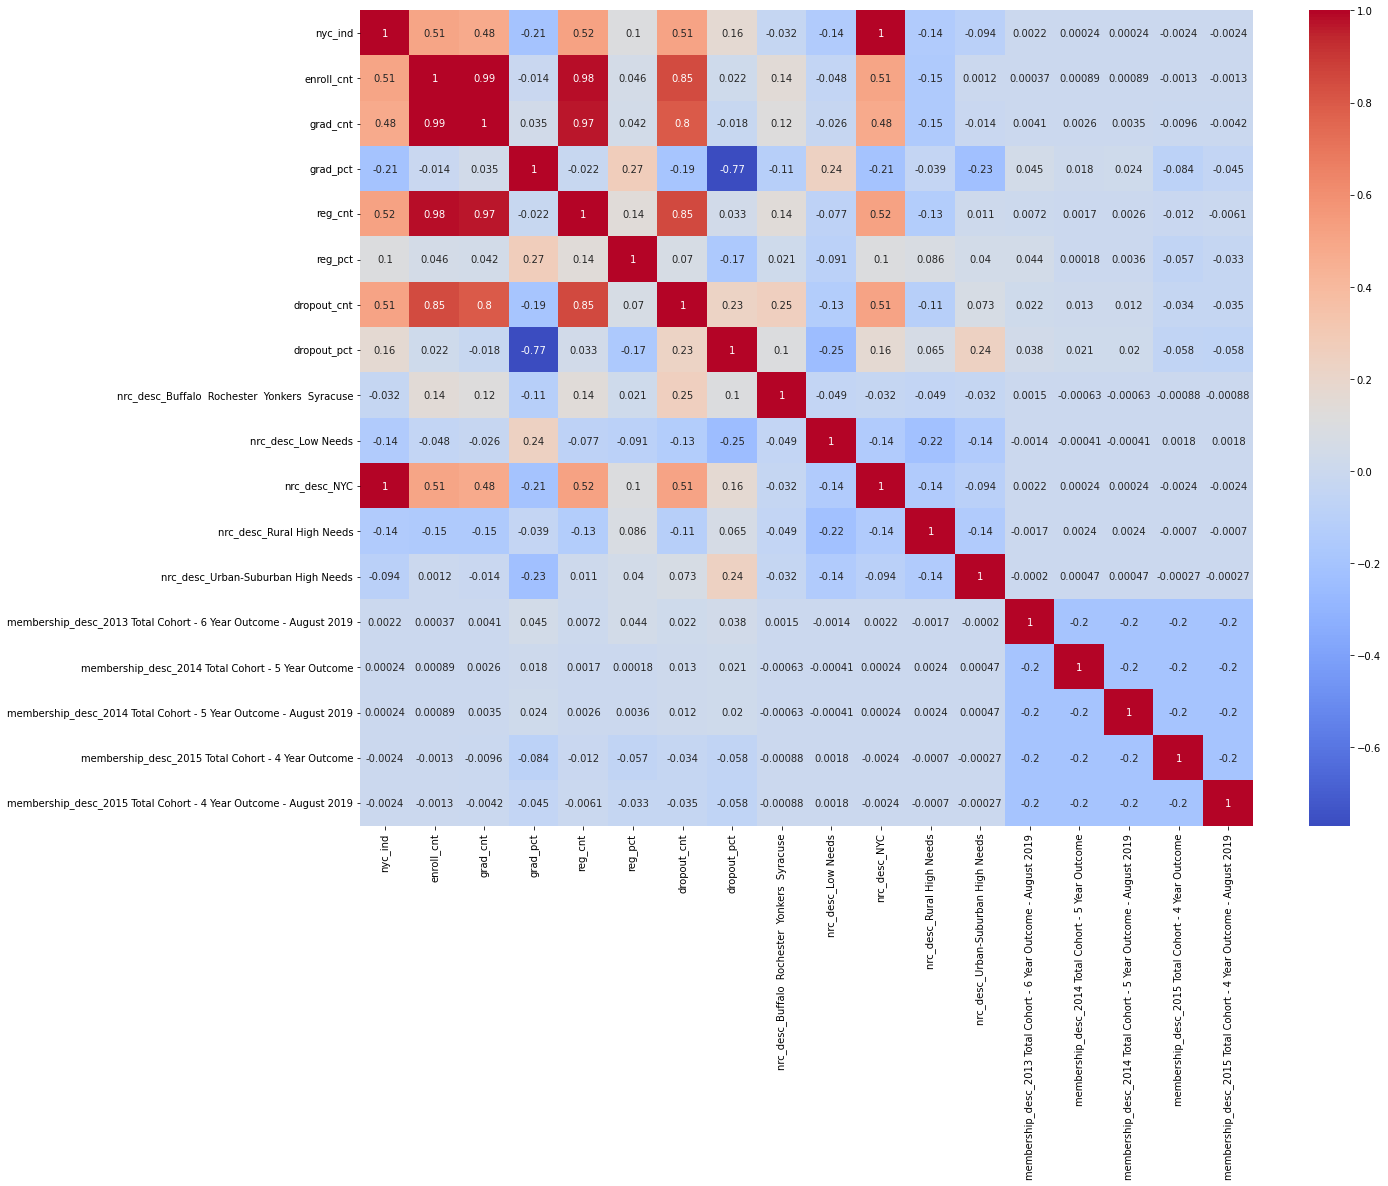

In [27]:
plt.figure(figsize=(20,15))
sns.heatmap(df3.corr(), annot=True, cmap='coolwarm')

In trying to explore the data some more after being transformed, we look at a correlation heatmap to try and identify some variables that may be introducing unwanted noise and multicollinearity. One worrying area in this chart is the top left corner, where most of the numeric predictors are located. The level of correlation between the "cnt"s is extremely high. From a logical perspective, this makes sense. The larger the student enrollment, the larger the amount of students that can fall into those other classifications. As mentioned earlier, it will be redundant to include both the "cnt" and "pct" values of each numeric variable and we will have to remove either the "pct"s or the "cnt"s. Based on the level of collinearity between the "cnt"s we will remove the "cnt" columns, with the exception of enroll_cnt, to reduce the multicollinearity. 
We will largely leave the "pct"s untouched, only removing reg_pct since the new response variable mirrors it. Another benefit of removing "cnt"s and keeping "pct"s is that the value is that the "pct" gives less weight to enroll_cnt when it comes to comparing the different "pct" levels among observations.

In addition to these numeric columns, a categorical correlation that is worryingly high is between nyc_ind and nrc_desc_NYC. They have 100% correlation since they are essentially saying the same thing. We will choose to drop the nyc_ind attribute so as to keep all aspects of nrc_desc even when broken down into dummies. This is somewhat arbitrary.

In [28]:
df4 = df3.drop(columns=['nyc_ind','grad_cnt','reg_cnt','reg_pct','dropout_cnt']).copy()
print(df4.shape)
df4.head()

(39674, 14)


,enroll_cnt,grad_pct,dropout_pct,reg_pct_level,nrc_desc_Buffalo Rochester Yonkers Syracuse,nrc_desc_Low Needs,nrc_desc_NYC,nrc_desc_Rural High Needs,nrc_desc_Urban-Suburban High Needs,membership_desc_2013 Total Cohort - 6 Year Outcome - August 2019,membership_desc_2014 Total Cohort - 5 Year Outcome,membership_desc_2014 Total Cohort - 5 Year Outcome - August 2019,membership_desc_2015 Total Cohort - 4 Year Outcome,membership_desc_2015 Total Cohort - 4 Year Outcome - August 2019
0,658.0,0.71,0.22,medium,0,0,0,0,1,0,0,0,0,0
1,324.0,0.76,0.20,medium,0,0,0,0,1,0,0,0,0,0
2,334.0,0.65,0.25,medium,0,0,0,0,1,0,0,0,0,0
4,367.0,0.68,0.25,medium,0,0,0,0,1,0,0,0,0,0
5,98.0,0.59,0.29,medium,0,0,0,0,1,0,0,0,0,0


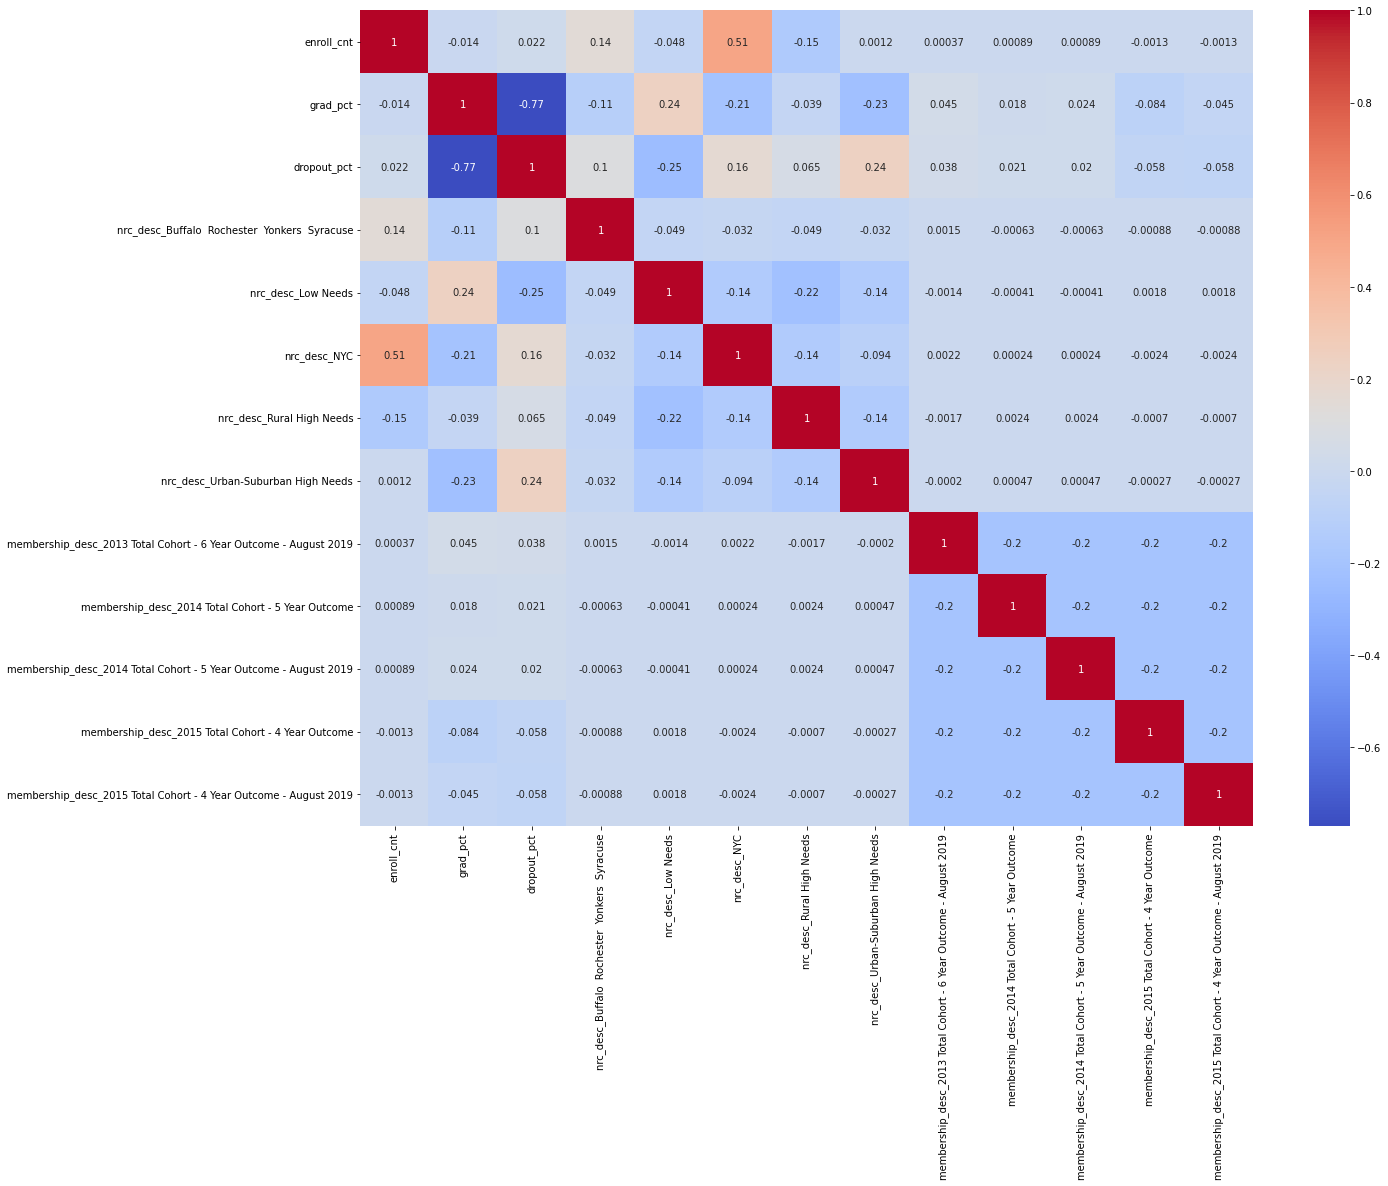

In [29]:
plt.figure(figsize=(20,15))
sns.heatmap(df4.corr(), annot=True, cmap='coolwarm')

Rechecking the heatmap, the only variable connection with a worrying level of correlation is grad_pct and dropout_pct. A possible reason for this is that the higher the amount of students dropping out, the lower the amount of students who will graduate and vice versa. While this isn't completely true since students can drop out of school at any level, not necessarily right before they graduate, one still does impact the other. However, because there is that possibility of a student dropping out not in a graduating year and since the correlation rate is only just over the typical threshold of +/-70% correlation, I will choose to keep both in. 

# Modeling

In [30]:
x = df4.drop(columns='reg_pct_level').copy()
y = df4.reg_pct_level

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Decision Tree One:

For the first model, we will choose the variables based on a correlation ranking compared to the response variable. Even though the response variable is categorical, since it is ordinal we can transform it into numeric values for the sake of evaluating the correlation. Using this method, the variables with the highest correlation values are grad_pct, dropout_pct, nrc_desc_Low Needs, and nrc_desc_Rural High Needs. 

For the first model, I will use the arbitraty value of 3 for max_depth so that it is possible to read the tree more easily and using the method of taking the square root of the amount of observations for the min samples to split on.

In [31]:
df4['reg_rnk1'] = np.where(df4.reg_pct_level=='low',1,np.where(df4.reg_pct_level=='medium',2,3))
df4.corr()['reg_rnk1'].sort_values(ascending=False)

reg_rnk1                                                            1.000000
grad_pct                                                            0.279924
nrc_desc_Rural High Needs                                           0.048297
nrc_desc_NYC                                                        0.040992
nrc_desc_Buffalo  Rochester  Yonkers  Syracuse                      0.032191
membership_desc_2013 Total Cohort - 6 Year Outcome - August 2019    0.025184
enroll_cnt                                                          0.010010
membership_desc_2014 Total Cohort - 5 Year Outcome - August 2019    0.005356
membership_desc_2014 Total Cohort - 5 Year Outcome                  0.003638
nrc_desc_Urban-Suburban High Needs                                 -0.006946
membership_desc_2015 Total Cohort - 4 Year Outcome - August 2019   -0.023279
membership_desc_2015 Total Cohort - 4 Year Outcome                 -0.035126
nrc_desc_Low Needs                                                 -0.069470

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
x1 = x_train[['grad_pct','dropout_pct','nrc_desc_Low Needs','nrc_desc_Rural High Needs']]


mins = int(round(np.sqrt(len(x1)),0))
model1 = DecisionTreeClassifier(max_depth=3, min_samples_split=mins, random_state=42)
model1.fit(x1, y_train)
scores = cross_val_score(model1, x1, y_train, cv=10)

for i in range(len(scores)):
  print(scores[i])
print('Avg Scores:', np.mean(scores))
print('Variables: grad_pct, dropout_pct, nrc_desc_Low Needs, nrc_desc_Rural High Needs')

0.8304977945809704
0.8229363579080026
0.8216761184625079
0.8241965973534972
0.8238815374921235
0.8257718966603654
0.8216761184625079
0.8245116572148709
0.8273471959672338
0.8285534194768358
Avg Scores: 0.8251048693578916
Variables: grad_pct, dropout_pct, nrc_desc_Low Needs, nrc_desc_Rural High Needs


Using these conditions, we achieve a score of 82.5% which is pretty good, but we will still need to evaluate other models with different variables and parameters.

### Decision Tree Two:

For the second tree, I will select features by first using all features and then using the features deemed most important by gini score.

I will use default parameters for this model and even though I will risk overfitting by using default parameters with all variables, I will be removing attributes based on that score.

Additionally, should this model be selected, I would apply a cross validation process in the testing to find the best hyperparameters that maximize these attributes.

In [33]:
model2 = DecisionTreeClassifier(random_state=42)
model2.fit(x_train, y_train)

for col, val in sorted(
    zip(x_train.columns, model2.feature_importances_),
    key = lambda x: x[1],
    reverse = True,
)[:4]:
  print(f"{col:10}{val:10.3f}")

enroll_cnt     0.388
grad_pct       0.244
dropout_pct     0.151
nrc_desc_Low Needs     0.035


This method of feature selection returns almost all the same features as the first method of feature selection.

In [34]:
x2 = x_train[['enroll_cnt','grad_pct','dropout_pct','nrc_desc_Low Needs']]

model2 = DecisionTreeClassifier(random_state=42)
model2.fit(x2, y_train)
scores = cross_val_score(model2, x2, y_train, cv=10)

for i in range(len(scores)):
  print(scores[i])
print('Avg Scores:', np.mean(scores))
print('Variables: enroll_cnt, dropout_pct, grad_pct, nrc_desc_Low Needs')

0.8487712665406427
0.8412098298676749
0.8434152488972905
0.8431001890359168
0.8405797101449275
0.8399495904221802
0.8481411468178954
0.8421550094517959
0.853182104599874
0.8506145603529782
Avg Scores: 0.8451118656131177
Variables: enroll_cnt, dropout_pct, grad_pct, nrc_desc_Low Needs


This method provided an average accuracy of 84.5% which is better than the second model. However, since we used default parameter values we have to take into consideration the fact that there is a very large risk of overfitting. 

### Random Forest One:

For the first model, I will select the numeric predictors with the highest correlation to the response variable and I will select the categorical variables with the most observations appearing in the data set. My logic behind choosing the categorical variables using this strategy is that the more observations that occur, the more insight there is to be gained from them in a decision model. 

For the hyperparameters, I will keep the same as the first decision tree model since my feature selection method is similar. For the amount of trees I will keep the default 10.

In [35]:
df4['reg_rnk1'] = np.where(df4.reg_pct_level=='low',1,np.where(df4.reg_pct_level=='medium',2,3))
df4.corr()['reg_rnk1'].sort_values(ascending=False)

reg_rnk1                                                            1.000000
grad_pct                                                            0.279924
nrc_desc_Rural High Needs                                           0.048297
nrc_desc_NYC                                                        0.040992
nrc_desc_Buffalo  Rochester  Yonkers  Syracuse                      0.032191
membership_desc_2013 Total Cohort - 6 Year Outcome - August 2019    0.025184
enroll_cnt                                                          0.010010
membership_desc_2014 Total Cohort - 5 Year Outcome - August 2019    0.005356
membership_desc_2014 Total Cohort - 5 Year Outcome                  0.003638
nrc_desc_Urban-Suburban High Needs                                 -0.006946
membership_desc_2015 Total Cohort - 4 Year Outcome - August 2019   -0.023279
membership_desc_2015 Total Cohort - 4 Year Outcome                 -0.035126
nrc_desc_Low Needs                                                 -0.069470

In [36]:
from collections import defaultdict
cnts = {}
rng = df4.iloc[:,4:]
keys = rng.columns

for i in range(len(rng.columns)):
  cnts[keys[i]] = sum(rng.iloc[:,i])/len(rng)
cnts

{'membership_desc_2013 Total Cohort - 6 Year Outcome - August 2019': 0.16436457125573423,
 'membership_desc_2014 Total Cohort - 5 Year Outcome': 0.16736401673640167,
 'membership_desc_2014 Total Cohort - 5 Year Outcome - August 2019': 0.16736401673640167,
 'membership_desc_2015 Total Cohort - 4 Year Outcome': 0.16827141200786408,
 'membership_desc_2015 Total Cohort - 4 Year Outcome - August 2019': 0.16827141200786408,
 'nrc_desc_Buffalo  Rochester  Yonkers  Syracuse': 0.010989564954378183,
 'nrc_desc_Low Needs': 0.1798659071432172,
 'nrc_desc_NYC': 0.08524474466905278,
 'nrc_desc_Rural High Needs': 0.17764782981297575,
 'nrc_desc_Urban-Suburban High Needs': 0.08600090739527146,
 'reg_rnk1': 1.9895649543781821}

The numeric variables with highest correlation are grad_pct and dropout_pct and the categorical variables with the highest amount of observations are nrc_desc_Low Needs and nrc_desc_Rural High Needs. Note that these are the same variables as the first decision tree model (this was not intentional).

In [37]:
from sklearn.ensemble import RandomForestClassifier

x3 = x_train[['grad_pct','dropout_pct','nrc_desc_Low Needs','nrc_desc_Rural High Needs']]
mins = int(round(np.sqrt(len(x3)),0))
model3 = RandomForestClassifier(n_estimators=10, max_depth=3, min_samples_split=mins)
model3.fit(x3, y_train)
scores = cross_val_score(model3, x3, y_train, cv=10)

for i in range(len(scores)):
  print(scores[i])
print('Avg Scores:', np.mean(scores))
print('Variables: grad_pct, dropout_pct, nrc_desc_Low Needs, nrc_desc_Rural High Needs')

0.8254568367989918
0.8226212980466289
0.8229363579080026
0.8210459987397606
0.8245116572148709
0.8279773156899811
0.8223062381852552
0.8241965973534972
0.8282923755513547
0.8282382603214623
Avg Scores: 0.8247582935809806
Variables: grad_pct, dropout_pct, nrc_desc_Low Needs, nrc_desc_Rural High Needs


With an average score of 82.46%, this random forest performs slightly worse than the first decision tree model which uses nearly identical parameters and features.

### Random Forest Two:

For this second random forest, I will use a similar strategy to the second decision tree of using the features deemed most important by gini score after using all default parameters. Then tuning the parameters at the end, should this model be selected, by running a more extensive cross validation process to perfect the model.

In addition to tuning the best parameters later if selected, we don't have to worry as much about overfitting since we are training a random forest and not a typical decision tree.

In [38]:
model4 = RandomForestClassifier(random_state=42)
model4.fit(x_train, y_train)

for col, val in sorted(
    zip(x_train.columns, model4.feature_importances_),
    key = lambda x: x[1],
    reverse = True,
)[:4]:
  print(f"{col:10}{val:10.3f}")

enroll_cnt     0.450
grad_pct       0.281
dropout_pct     0.144
nrc_desc_Low Needs     0.039


We are left with the variables enroll_cnt, grad_pct, dropout_pct, and nrc_desc_Low Needs. This is again identical to the second decision tree model (again not intentional).

In [39]:
x4 = x_train[['enroll_cnt','grad_pct','dropout_pct','nrc_desc_Low Needs']]

model4 = RandomForestClassifier(random_state=42)
model4.fit(x4, y_train)
scores = cross_val_score(model4, x4, y_train, cv=10)

for i in range(len(scores)):
  print(scores[i])
print('Avg Scores:', np.mean(scores))
print('Variables: enroll_cnt, dropout_pct, grad_pct, nrc_desc_Low Needs')

0.8575929426591052
0.853182104599874
0.848456206679269
0.848456206679269
0.8538122243226213
0.850346565847511
0.8591682419659735
0.852236925015753
0.8607435412728418
0.8562874251497006
Avg Scores: 0.8540282384191918
Variables: enroll_cnt, dropout_pct, grad_pct, nrc_desc_Low Needs


This second random forest model performs the best out of the four running at an average of 85.4%. Since it's a random forest, it should theoretically decrease overfitting and there is still the opportunity to perfect hyperparameters should this model be chosen.

# Model Selection

Out of the four models run, two decision trees and two random forests, I will elect to move forward with the second decision tree model. At first glance it would seem obvious to go with the second random forest model since it works on similar criteria with the same features selected. However, there is only a one percent increase in accuracy from the random forest and it is more computationally expensive. Additionally, we will likely be able to improve the performance of the model by running it through more manual cross validations to select the optimal parameters based on the test data set.

The source for this method can be found here: https://www.section.io/engineering-education/hyperparmeter-tuning/

In [40]:
model2.tree_.max_depth

35

In [41]:
x_test1 = x_test[['enroll_cnt','grad_pct','dropout_pct','nrc_desc_Low Needs']]

for max_d in range(1, 36):
  model = DecisionTreeClassifier(max_depth=max_d, random_state=42)
  model.fit(x_test1, y_test)
  print('The Training Accuracy for max_depth {} is:'.format(max_d),model.score(x2,y_train))
  print('The Validation Accuracy for max_depth {} is:'.format(max_d),model.score(x_test1,y_test))
  print('')

The Training Accuracy for max_depth 1 is: 0.8182677463058068
The Validation Accuracy for max_depth 1 is: 0.8233144297416509

The Training Accuracy for max_depth 2 is: 0.8227732442736067
The Validation Accuracy for max_depth 2 is: 0.8281033396345305

The Training Accuracy for max_depth 3 is: 0.8238129745738682
The Validation Accuracy for max_depth 3 is: 0.8294896030245746

The Training Accuracy for max_depth 4 is: 0.8237499606162765
The Validation Accuracy for max_depth 4 is: 0.8306238185255198

The Training Accuracy for max_depth 5 is: 0.8244746211285799
The Validation Accuracy for max_depth 5 is: 0.8320100819155639

The Training Accuracy for max_depth 6 is: 0.8239390024890513
The Validation Accuracy for max_depth 6 is: 0.83528670447385

The Training Accuracy for max_depth 7 is: 0.8225842024008317
The Validation Accuracy for max_depth 7 is: 0.8391934467548834

The Training Accuracy for max_depth 8 is: 0.824317086234601
The Validation Accuracy for max_depth 8 is: 0.844234404536862

The 

We choose the value of max_depth = 11 since this is where the training data starts dipping and validation starts rising even faster. 

In [42]:
  model = DecisionTreeClassifier(max_depth=11, random_state=42)
  model.fit(x_test1, y_test)
  model.score(x_test1, y_test)

0.8641461877756774

Using this model with the tested max depth of 11, we end up with a very good score of 86.4%.

# Conclusion

After training these models using the variables selected, we are left with the tough decision that comes up a lot in machine learning and data science, efficiency vs accuracy. Thankfully, we are able to get a satisfying result even while going with the more efficient option. If we would go deeper, a suggestion to tuning parameters would be to split the initial training set into smaller training and validation sets and apply the more manual method of cross validation displayed in the model selection step to fine tune the parameters to build the best model. While the second random forest model still may have performed better after going through a similar parameter tuning process that the second decision tree model went through at the end, we are still able to come up with a satisfying result even while going with the more efficient option and theoretically, less accurate option.